In [118]:
import numpy as np
import random

**FORWARD SIMULATION**

In [119]:
def forward_sim(n,T, alpha=0.9, gamma=0.1, beta=0.2, lmda=(1, 5)): 
    Gamma = [[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]]
    Z_prob = [[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]]
    C = np.zeros(T,dtype=int)
    Z = np.zeros((T,n), dtype=int)
    X = np.zeros((T,n), dtype=int)
    C[0] = 2
    for i in range(0,n):
            Z[0,i] = random.choices([0,1], Z_prob[C[0]], k = 1)[0]
            X[0,i] = np.random.poisson(lam = lmda[Z[0,i]])

    for t in range(1,T):
        C[t] = random.choices([0,1,2], Gamma[C[t-1]], k = 1)[0]
        for i in range(0,n):
            Z[t,i] = random.choices([0,1], Z_prob[C[t]], k = 1)[0]
            X[t,i] = np.random.poisson(lam = lmda[Z[t,i]])
    return C, Z, X



     



In [ ]:
C, Z, X = forward_sim(10,1000)

**VISUALIZATION**

In [121]:
import matplotlib.pyplot as plt

In [122]:
avg_Z = np.mean(Z, axis=1).reshape(1,-1)[0]
avg_X = np.mean(X, axis=1).reshape(1,-1)[0]

In [123]:
t = range(len(C))
t

range(0, 50)

In [124]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

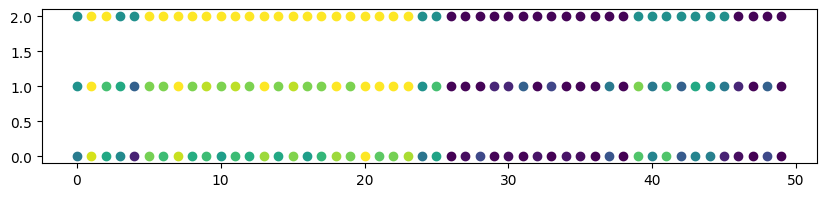

In [126]:
c_col = range(len(C))  
plt.figure(figsize=(int(len(C)/5),int(len(C)/25)))
cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(0, 1)
# Plot each point individually with the specified colors and adjusted x-coordinates
for i, value in enumerate(C):
    
    if value == 0:
        color = cmap(0)
        plt.plot(i, 2, color = color, marker = 'o')  # Red marker
    elif value == 1:
        color = cmap(0.99)
        plt.plot(i, 2, color = color,  marker = 'o')  # Blue marker
    elif value == 2:
        color = cmap(0.5)
        plt.plot(i, 2, color = color,  marker = 'o')  # Magenta (purple) marker


for i, value in enumerate(normalize(avg_Z, 0, 0.99)): 
    color = cmap(value)
    plt.plot(i, 1, color = color,  marker = 'o')


for i, value in enumerate(normalize(avg_X, 0, 1.2)): 
    color = cmap(norm(value))
    plt.plot(i, 0, color = color,  marker = 'o')


plt.show()





**MULTICLASS LOGISTIC REGRESSION**